In [1]:
import json
import os
import matplotlib.pyplot as plt

In [2]:
def get_complete_results(base_directory):
    results_complete = {}
    for folder_name in os.listdir(base_directory):
        folder_path = os.path.join(base_directory, folder_name)
        if os.path.isdir(folder_path):
            results_complete[folder_name] = []
            for file_name in os.listdir(folder_path):
                if file_name.endswith(".json"):
                    file_path = os.path.join(folder_path, file_name)
                    with open(file_path, "r") as f:
                        data = json.load(f)
                        results_complete[folder_name].append(
                            {"key": int(file_name.split(".")[0]), "data": data}
                        )
        for key in results_complete.keys():
            results_complete[key] = sorted(
                results_complete[key], key=lambda x: x["key"]
            )
    return results_complete


def get_final_scores(results_complete):
    scores = {}
    for method in results_complete.keys():
        scores[method] = []
        for result in results_complete[method]:
            score = 100
            solved = False
            cost = 1
            prompt_tokens = 0
            completion_tokens = 0
            for op in result["data"]:
                if "operation" in op and op["operation"] == "ground_truth_evaluator":
                    try:
                        score = min(op["scores"])
                        solved = any(op["problem_solved"])
                    except:
                        continue
                if "cost" in op:
                    cost = op["cost"]
                    prompt_tokens = op["prompt_tokens"]
                    completion_tokens = op["completion_tokens"]
            scores[method].append(
                [result["key"], score, solved, prompt_tokens, completion_tokens, cost]
            )
        scores[method] = sorted(scores[method], key=lambda x: x[0])
    return scores


def get_plotting_data(base_directory):
    results_complete = get_complete_results(base_directory)
    scores = get_final_scores(results_complete)
    results_plotting = {
        method: {
            "scores": [x[1] for x in scores[method]],
            "solved": sum([1 for x in scores[method] if x[2]]),
            "costs": [x[5] for x in scores[method]],
        }
        for method in scores.keys()
    }
    return results_plotting


def plot_results(
    results,
    methods_order=["io", "cot", "tot", "tot2", "got"],
    model="GPT-3.5",
    length=32,
    y_lower=0,
    cost_upper=0.0,
    display_solved=True,
    annotation_offset=0,
    display_left_ylabel=False,
    display_right_ylabel=False,
):
    methods_order = [method for method in methods_order if method in results]
    # Extract scores based on the order
    scores_ordered = [
        [
            min(score, length)
            for score in results[method]["scores"]
            if score != 100 and score != 300
        ]
        for method in methods_order
    ]
    total_costs = [sum(results[method]["costs"]) for method in methods_order]

    # Create figure and axis
    fig, ax = plt.subplots(dpi=150, figsize=(2.5, 5))

    # Create boxplots
    positions = range(1, len(methods_order) + 1)
    ax.boxplot(scores_ordered, positions=positions)

    fig_fontsize = 12

    # Set the ticks and labels
    method_labels = ["IO", "CoT", "ToT", "ToT2", "GoT"]
    plt.yticks(fontsize=fig_fontsize)
    ax.set_xticks(range(1, len(methods_order) + 1))
    ax.set_xticks(range(1, len(methods_order) + 1))
    ax.set_xticklabels(method_labels, fontsize=fig_fontsize)

    y_upper = length

    range_increase = 1
    if display_solved:
        if length < 48:
            range_increase = 2
        elif length < 96:
            range_increase = 4
        else:
            range_increase = 8

    ax.set_ylim(y_lower, y_upper + range_increase)
    ax1_yticks = range(
        y_lower, y_upper + 1, 2 if length < 48 else (4 if length < 96 else 8)
    )
    ax.set_yticks(ax1_yticks)
    if display_left_ylabel:
        ax.set_ylabel(f"#incorrectly sorted elements; the lower the better")

    ax.set_title(f"{length} elements")

    ax2 = ax.twinx()
    ax2.bar(positions, total_costs, alpha=0.5, color="blue", label="Total Cost ($)")
    ax2.yaxis.set_tick_params(colors="#1919ff", labelsize=fig_fontsize)
    if cost_upper > 0:
        ax2.set_ylim(0, cost_upper)
        number_of_ticks = len(ax.get_yticks())
        tick_interval = cost_upper / (number_of_ticks)
        ax2_ticks = [tick_interval * i for i in range(number_of_ticks)]

        # Set custom tick positions for ax2
        ax2.set_yticks(ax2_ticks)

    if display_right_ylabel:
        ax2.set_ylabel(
            "Total Cost ($); the lower the better",
            color="#1919ff",
            fontsize=fig_fontsize,
        )

    if display_solved:
        annotation_height = y_upper + annotation_offset
        count = 1
        for method in methods_order:
            if method not in results:
                continue
            solved = results[method]["solved"]
            ax.text(
                count,
                annotation_height,
                f"{solved}",
                ha="center",
                va="bottom",
                fontsize=fig_fontsize,
            )
            count += 1

    model = model.replace(".", "").replace("-", "").lower()
    fig.savefig(f"sorting_{model}_{length}.pdf", bbox_inches="tight")

In [4]:
import os

In [5]:
os.getcwd()

'/Users/marcinsawinski/Documents/GitHub/graph-of-thoughts/examples/sorting'

In [12]:
results_complete = get_complete_results("/Users/marcinsawinski/Documents/GitHub/graph-of-thoughts/examples/sorting/results/")
scores = get_final_scores(results_complete)
results_plotting = {
    method: {
        "scores": [x[1] for x in scores[method]],
        "solved": sum([1 for x in scores[method] if x[2]]),
        "costs": [x[5] for x in scores[method]],
    }
    for method in scores.keys()
}


In [13]:
results_complete

{'azurechatgpt_io-cot-tot-tot2-got_2023-10-14_20-51-14': []}

In [35]:
base_directory = "/Users/marcinsawinski/Documents/GitHub/graph-of-thoughts/examples/sorting/results/azurechatgpt_io-cot-tot-tot2-got_2023-10-14_20-51-14"
results_complete = {}
for folder_name in os.listdir(base_directory):
    folder_path = os.path.join(base_directory, folder_name)
    print('folder_path: ',folder_path)
    if os.path.isdir(folder_path):
        results_complete[folder_name] = []
        for file_name in os.listdir(folder_path):
            if file_name.endswith(".json"):
                file_path = os.path.join(folder_path, file_name)
                print(file_path)
                with open(file_path, "r") as f:
                    data = json.load(f)
                    results_complete[folder_name].append(
                        {"key": int(file_name.split(".")[0]), "data": data}
                    )
    for key in results_complete.keys():
        results_complete[key] = sorted(
            results_complete[key], key=lambda x: x["key"]
        )

folder_path:  /Users/marcinsawinski/Documents/GitHub/graph-of-thoughts/examples/sorting/results/azurechatgpt_io-cot-tot-tot2-got_2023-10-14_20-51-14/log.log
folder_path:  /Users/marcinsawinski/Documents/GitHub/graph-of-thoughts/examples/sorting/results/azurechatgpt_io-cot-tot-tot2-got_2023-10-14_20-51-14/io
/Users/marcinsawinski/Documents/GitHub/graph-of-thoughts/examples/sorting/results/azurechatgpt_io-cot-tot-tot2-got_2023-10-14_20-51-14/io/0.json
/Users/marcinsawinski/Documents/GitHub/graph-of-thoughts/examples/sorting/results/azurechatgpt_io-cot-tot-tot2-got_2023-10-14_20-51-14/io/1.json
/Users/marcinsawinski/Documents/GitHub/graph-of-thoughts/examples/sorting/results/azurechatgpt_io-cot-tot-tot2-got_2023-10-14_20-51-14/io/2.json
folder_path:  /Users/marcinsawinski/Documents/GitHub/graph-of-thoughts/examples/sorting/results/azurechatgpt_io-cot-tot-tot2-got_2023-10-14_20-51-14/got
/Users/marcinsawinski/Documents/GitHub/graph-of-thoughts/examples/sorting/results/azurechatgpt_io-cot-t

In [34]:
os.listdir(base_directory)

['azurechatgpt_io-cot-tot-tot2-got_2023-10-14_20-51-14']

In [31]:
os.listdir(base_directory)

FileNotFoundError: [Errno 2] No such file or directory: 'results/got/'

In [28]:
os.listdir(folder_path)

['log.log', 'io', 'got', 'cot', 'config.jsonx', 'tot', 'tot2']

In [24]:
folder_name

'azurechatgpt_io-cot-tot-tot2-got_2023-10-14_20-51-14'

In [21]:
os.getcwd()

'/Users/marcinsawinski/Documents/GitHub/graph-of-thoughts/examples/sorting'

In [22]:
folder_path

'/Users/marcinsawinski/Documents/GitHub/graph-of-thoughts/examples/sorting/results/azurechatgpt_io-cot-tot-tot2-got_2023-10-14_20-51-14'

In [20]:
folder_name

'azurechatgpt_io-cot-tot-tot2-got_2023-10-14_20-51-14'

In [15]:
results_complete

{'azurechatgpt_io-cot-tot-tot2-got_2023-10-14_20-51-14': []}

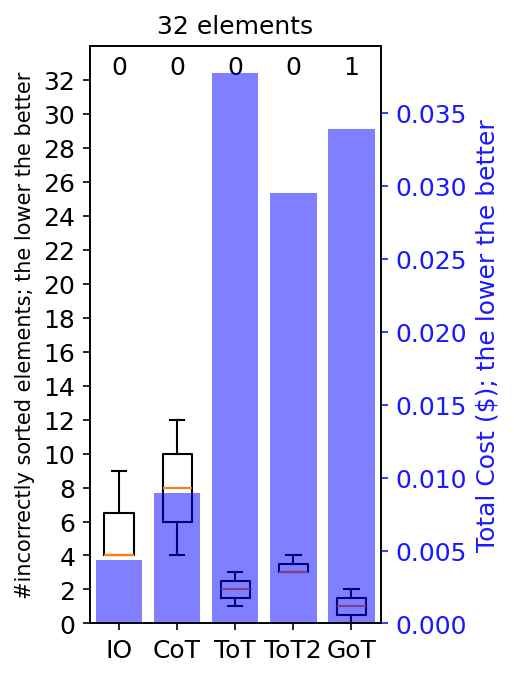

In [36]:
plot_results(
    get_plotting_data("results/azurechatgpt_io-cot-tot-tot2-got_2023-10-14_20-51-14"),
    length=32,
    display_solved=True,
    model="GPT-3.5",
    display_left_ylabel=True,
    display_right_ylabel=True,
)